In [1]:
# On a machine with CUDA 11.8
!pip install --upgrade pip
!pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install pennylane pennylane-lightning matplotlib scikit-learn shap pandas tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 127.4 MB/s  0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 172.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 136.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 173.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 169.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 180.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [pennylane]12 [pennylane]lightning]


In [6]:
# ===============================================================
# CELL 1 — Basic Setup (RUN THIS FIRST)
# ===============================================================

import os
import time
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

import pennylane as qml

# ---------------- Device ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Torch Device:", DEVICE)

# ---------------- Quantum Device ----------------
n_qubits = 3
n_layers = 2
N_COMPONENTS = 5

if DEVICE.type == "cuda":
    try:
        dev = qml.device("lightning.gpu", wires=n_qubits, shots=None)
        print("Using PennyLane device: lightning.gpu")
    except:
        dev = qml.device("default.qubit", wires=n_qubits, shots=None)
        print("Fallback to PennyLane device: default.qubit")
else:
    dev = qml.device("default.qubit", wires=n_qubits, shots=None)
    print("Using PennyLane device: default.qubit")

print("Setup complete.")

Using Torch Device: cpu
Using PennyLane device: default.qubit
Setup complete.


In [7]:
# ===============================================================
# CELL 2 — Data Loading + Feature Engineering
# ===============================================================

# ---------------- Load Data ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

print("Total rows:", len(df))
print("Total reactions:", df["Reaction"].nunique())

# ---------------- Physics Feature Engineering ----------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values

v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999

df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# ---------------- S-factor residual ----------------
log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# ---------------- Extra Physics Features ----------------
df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"] * df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2, 8, 20, 28, 50, 82, 126])

def magic_dist(arr):
    return np.min(np.abs(arr[:, None] - MAGIC[None, :]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

print("Feature engineering complete.")

Total rows: 3532
Total reactions: 213
Feature engineering complete.


In [8]:
# ===============================================================
# CELL 3 — SAME Reaction Split + Scaling
# ===============================================================

# ---------------- 29 Training Features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Load SAME reaction split from classical run ----------------
BASE_DIR = "mdn_70_10_20_optimized"

train_reacts = pd.read_csv(os.path.join(BASE_DIR, "train_reactions.csv"))["Reaction"].values
val_reacts   = pd.read_csv(os.path.join(BASE_DIR, "val_reactions.csv"))["Reaction"].values
test_reacts  = pd.read_csv(os.path.join(BASE_DIR, "test_reactions.csv"))["Reaction"].values

print("Train reactions:", len(train_reacts))
print("Val reactions:", len(val_reacts))
print("Test reactions:", len(test_reacts))

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

# ---------------- Prepare Data ----------------
X_train_full = df.loc[train_mask | val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask | val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

# ---------------- Scaling (same as classical) ----------------
scaler = StandardScaler().fit(X_train_full)

X_train_full_s = scaler.transform(X_train_full)
X_test_s = scaler.transform(X_test)

print("Training samples:", X_train_full_s.shape[0])
print("Test samples:", X_test_s.shape[0])
print("Data ready.")

Train reactions: 149
Val reactions: 21
Test reactions: 43
Training samples: 2847
Test samples: 685
Data ready.


In [9]:
# ===============================================================
# CELL 4 — QMDN Model Definition (5 Components Only)
# ===============================================================

# ----- Quantum Node -----
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(weights, inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))


class QMDN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        # Classical encoder
        self.encoder = nn.Linear(in_dim, n_qubits)

        # Quantum circuit parameters
        init = 0.01
        self.w_pi  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_mu  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_sig = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        B = x.shape[0]
        x_enc = torch.tanh(self.encoder(x)).float()

        pi_list, mu_list, sigma_list = [], [], []

        for i in range(B):
            inp = x_enc[i]

            p_pi  = qnode(self.w_pi, inp)
            p_mu  = qnode(self.w_mu, inp)
            p_sig = qnode(self.w_sig, inp)

            p_pi  = p_pi.to(DEVICE)
            p_mu  = p_mu.to(DEVICE)
            p_sig = p_sig.to(DEVICE)

            # ---- Keep only first 5 basis states ----
            pi_raw  = p_pi[:N_COMPONENTS]
            mu_raw  = p_mu[:N_COMPONENTS]
            sig_raw = p_sig[:N_COMPONENTS]

            # Normalize mixture
            pi = pi_raw / (pi_raw.sum() + 1e-12)

            # Map to MDN parameters
            mu = torch.log(mu_raw + 1e-12)
            sigma = torch.nn.functional.softplus(sig_raw) + 1e-6

            pi_list.append(pi)
            mu_list.append(mu)
            sigma_list.append(sigma)

        return torch.stack(pi_list), torch.stack(mu_list), torch.stack(sigma_list)


# ----- MDN Loss (same as classical) -----
def mdn_loss(pi, mu, sigma, y):
    y_exp = y.repeat(1, mu.shape[1])
    log_gauss = -0.5 * ((y_exp - mu) / sigma)**2 - torch.log(sigma) - 0.5 * np.log(2*np.pi)
    log_mix = torch.logsumexp(torch.log(pi + 1e-12) + log_gauss, dim=1)
    return -log_mix.mean()


print("QMDN model defined.")

QMDN model defined.


In [11]:
# Required imports for training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [12]:
# ===============================================================
# CELL 5 — QMDN Training (Single Model)
# ===============================================================

# DataLoader helper (same style as classical)
def make_loader(X, y, batch=64, shuffle=True):
    return DataLoader(
        TensorDataset(torch.tensor(X), torch.tensor(y)),
        batch_size=batch,
        shuffle=shuffle
    )

# Create loaders
train_loader = make_loader(X_train_full_s, y_train_full, batch=64, shuffle=True)
test_loader  = make_loader(X_test_s, y_test, batch=64, shuffle=False)

# Instantiate model
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

MAX_EPOCHS = 60
best_loss = float("inf")
best_state = None

print("\n🚀 Starting QMDN Training\n")

for epoch in range(MAX_EPOCHS):
    
    # ---- Training ----
    model.train()
    train_loss = 0.0
    
    for xb, yb in train_loader:
        xb = xb.to(DEVICE).float()
        yb = yb.to(DEVICE).float()

        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # ---- Validation on Test set (temporary) ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()

            pi, mu, sigma = model(xb)
            val_loss += mdn_loss(pi, mu, sigma, yb).item() * xb.size(0)

    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch:03d} | Train NLL={train_loss:.6f} | Test NLL={val_loss:.6f}")

    # Save best
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

print("\nBest Test NLL:", best_loss)

# Load best model
model.load_state_dict(best_state)
torch.save(model.state_dict(), "qmdn_single_best.pth")

print("✅ QMDN training complete.")


🚀 Starting QMDN Training

Epoch 000 | Train NLL=1.149833 | Test NLL=1.071718
Epoch 001 | Train NLL=1.004455 | Test NLL=0.863388
Epoch 002 | Train NLL=0.799579 | Test NLL=0.664926
Epoch 003 | Train NLL=0.674020 | Test NLL=0.607188
Epoch 004 | Train NLL=0.638805 | Test NLL=0.601852
Epoch 005 | Train NLL=0.637906 | Test NLL=0.602115
Epoch 006 | Train NLL=0.637596 | Test NLL=0.601546
Epoch 007 | Train NLL=0.637349 | Test NLL=0.601803
Epoch 008 | Train NLL=0.637171 | Test NLL=0.601782
Epoch 009 | Train NLL=0.637308 | Test NLL=0.602331
Epoch 010 | Train NLL=0.637091 | Test NLL=0.601840
Epoch 011 | Train NLL=0.637006 | Test NLL=0.602347
Epoch 012 | Train NLL=0.636962 | Test NLL=0.602411
Epoch 013 | Train NLL=0.636954 | Test NLL=0.602143
Epoch 014 | Train NLL=0.636918 | Test NLL=0.601960
Epoch 015 | Train NLL=0.636733 | Test NLL=0.602553
Epoch 016 | Train NLL=0.636916 | Test NLL=0.602328
Epoch 017 | Train NLL=0.636757 | Test NLL=0.602412
Epoch 018 | Train NLL=0.636763 | Test NLL=0.602233
Epoc

In [13]:
# ===============================================================
# QMDN Test Evaluation (ARGMAX mode)
# ===============================================================

model.eval()

preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(DEVICE).float()
        pi, mu, sigma = model(xb)

        idx = pi.argmax(dim=1)
        y_pred = mu[torch.arange(len(mu)), idx]
        preds.append(y_pred.cpu().numpy())

y_pred_delta_q = np.concatenate(preds)

# --- Metrics ---
rmse_delta = np.sqrt(mean_squared_error(y_test.flatten(), y_pred_delta_q))
r2_delta = r2_score(y_test.flatten(), y_pred_delta_q)

print("QMDN Δlog10S RMSE:", rmse_delta)
print("QMDN Δlog10S R²:", r2_delta)

QMDN Δlog10S RMSE: 0.2211776458930174
QMDN Δlog10S R²: -0.04369926760362364


In [14]:
# --- Reconstruct sigma ---

test_local = df.loc[test_mask].reset_index(drop=True)

eta_test = test_local["eta"].values
log10_S_cal_test = test_local["log10_S_cal"].values
Ecm_test = test_local["E c.m."].values
sigma_true = test_local["σ"].values

log10_S_pred_q = log10_S_cal_test + y_pred_delta_q

log10_sigma_pred_q = (
    log10_S_pred_q
    - np.log10(Ecm_test + 1e-30)
    - (2*np.pi*eta_test)/np.log(10)
)

r2_log_sigma = r2_score(
    np.log10(sigma_true + 1e-30),
    log10_sigma_pred_q
)

print("QMDN logσ R²:", r2_log_sigma)

QMDN logσ R²: 0.9681354180942239


# This is to import saved models

In [ ]:
# Recreate model
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)

# Load weights
model.load_state_dict(torch.load("qmdn_single_best.pth", map_location=DEVICE))

model.eval()

print("QMDN model reloaded successfully.")

In [15]:
# Save full dataset components again
model.eval()

X_all = scaler.transform(df[features_train].values.astype(np.float32))

pi_all = []
mu_all = []
sigma_all = []

with torch.no_grad():
    for i in range(0, len(X_all), 64):
        xb = torch.tensor(X_all[i:i+64]).to(DEVICE).float()
        pi, mu, sigma = model(xb)
        pi_all.append(pi.cpu().numpy())
        mu_all.append(mu.cpu().numpy())
        sigma_all.append(sigma.cpu().numpy())

pi_all = np.vstack(pi_all)
mu_all = np.vstack(mu_all)
sigma_all = np.vstack(sigma_all)

np.savez("qmdn_all_components.npz",
         pi=pi_all,
         mu=mu_all,
         sigma=sigma_all)

print("Saved qmdn_all_components.npz")

Saved qmdn_all_components.npz


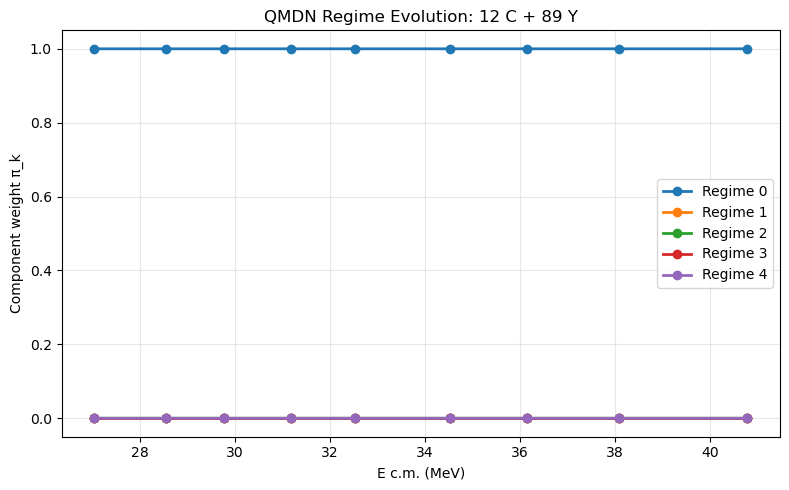

In [17]:
# ===============================================================
# QMDN Regime Evolution Plot (Single Reaction)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt

reaction_name = "12 C + 89 Y"   # <<< CHANGE to test others

# Load QMDN components
data_q = np.load("qmdn_all_components.npz")
pi_q = data_q["pi"]

# Extract reaction rows (sorted by energy)
rows_R = df[df["Reaction"] == reaction_name].copy()
rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True)

idx = rows_R.index  # sorted index

# Important: get original indices for this reaction
original_idx = df[df["Reaction"] == reaction_name].sort_values("E c.m.").index

pi_R = pi_q[original_idx]

E_R = rows_R["E c.m."].values

# Plot
plt.figure(figsize=(8,5))

for k in range(N_COMPONENTS):
    plt.plot(E_R, pi_R[:,k], marker='o', linewidth=2, label=f"Regime {k}")

plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight π_k")
plt.title(f"QMDN Regime Evolution: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Load QMDN components
data_q = np.load("qmdn_all_components.npz")
pi_q = data_q["pi"]

# Mean weight of each component over entire dataset
mean_pi = pi_q.mean(axis=0)

print("Global mean π per component:")
for k, val in enumerate(mean_pi):
    print(f"Component {k}: {val:.6f}")

Global mean π per component:
Component 0: 0.999979
Component 1: 0.000000
Component 2: 0.000019
Component 3: 0.000000
Component 4: 0.000001


In [19]:
# Which component is dominant per row?
dominant = np.argmax(pi_q, axis=1)

unique, counts = np.unique(dominant, return_counts=True)

print("Dominant component counts:")
for u, c in zip(unique, counts):
    print(f"Component {u}: {c}")

Dominant component counts:
Component 0: 3532


In [20]:
reaction_regime_count = {}

for reaction in df["Reaction"].unique():
    idx = df[df["Reaction"] == reaction].index
    dom = dominant[idx]
    reaction_regime_count[reaction] = len(np.unique(dom))

# How many reactions use >1 regime?
multi_regime = sum(1 for v in reaction_regime_count.values() if v > 1)

print("Reactions using >1 regime:", multi_regime)
print("Total reactions:", len(reaction_regime_count))

Reactions using >1 regime: 0
Total reactions: 213


In [2]:
# Cell 1: imports & reproducibility
import os, math, time, random
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm import tqdm

# seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [22]:
# Cell 2: load and compute S-factor features (adapted from your code)
# default url you used earlier — change if needed
csv_url = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI" #new corrected files

df = pd.read_csv(csv_url)
print("Loaded rows:", len(df))
# If column names differ, you may need to rename; the code below expects 'σ' column and either 'ECC_cal' or 'σ cal' etc.
if 'σ' not in df.columns:
    # try common alternatives
    for cand in ['sigma', 'sigma_exp', 'sigma_experiment']:
        if cand in df.columns:
            df.rename(columns={cand: 'σ'}, inplace=True)
if 'ECC_cal' not in df.columns:
    # try 'σ cal' or other
    if 'σ cal' in df.columns:
        df.rename(columns={'σ cal':'ECC_cal'}, inplace=True)
    elif 'σ_cal' in df.columns:
        df.rename(columns={'σ_cal':'ECC_cal'}, inplace=True)

# Physics constants
M_p = 938.272088; M_n = 939.565420; LN10 = np.log(10)
epsilon = 1e-30
e2_hbar_c = 1.0/137.035999
hbar_c = 197.326980

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

# compute masses and reduced mass
mass1 = df.apply(lambda r: get_nucleon_mass(r['Z1'], r['A1']), axis=1)
mass2 = df.apply(lambda r: get_nucleon_mass(r['Z2'], r['A2']), axis=1)
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2)

df["mu"] = (df["A1"] * df["A2"]) / (df["A1"] + df["A2"])
v_over_c = np.sqrt(2 * df["E c.m."] / mu_MeVc2)
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * v_over_c)

# log10 S computations (stable)
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-12, None))
log10_sigma_exp = np.log10(np.clip(df["σ"], epsilon, None))
log10_sigma_cal = np.log10(np.clip(df["ECC_cal"], epsilon, None))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2 * math.pi * df["eta"]) / LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2 * math.pi * df["eta"]) / LN10
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# extra features (match your 13-feature list)
df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"] * df["Z2"]) / (df["E c.m."] + epsilon)
MAGIC_NUMBERS = np.array([2,8,20,28,50,82,126])
def get_magic_distance(arr):
    vals = arr.values[:,None]
    dist = np.abs(vals - MAGIC_NUMBERS)
    return np.min(dist, axis=1)

df["magic_dist_Z1"] = get_magic_distance(df["Z1"])
df["magic_dist_N1"] = get_magic_distance(df["N1"])
df["magic_dist_Z2"] = get_magic_distance(df["Z2"])
df["magic_dist_N2"] = get_magic_distance(df["N2"])

print("Columns available:", df.columns.tolist())
print("Example rows:")
display(df.head())

# Drop rows with any NaNs in target
df = df.dropna(subset=["delta_log10_S"])
print("After drop NaN target rows:", len(df))


Loaded rows: 3532
Columns available: ['E c.m.', 'σ', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Z3', 'N3', 'A3', 'ECC_cal', 'β P', 'β T', 'R B', 'ħ ω', 'Q ( 2 n )', 'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual', 'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn', 'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy', 'Compound_Nucleus_S2n', 'Compound_Nucleus_S2p', 'Reaction', 'Unnamed: 28', 'mu', 'eta', 'log10_S_exp', 'log10_S_cal', 'delta_log10_S', 'Z1Z2_over_Ecm', 'magic_dist_Z1', 'magic_dist_N1', 'magic_dist_Z2', 'magic_dist_N2']
Example rows:


,E c.m.,σ,Z1,N1,A1,Z2,N2,A2,Z3,N3,...,mu,eta,log10_S_exp,log10_S_cal,delta_log10_S,Z1Z2_over_Ecm,magic_dist_Z1,magic_dist_N1,magic_dist_Z2,magic_dist_N2
0,27.037,0.033,6,6,12,39,50,89,45,56,...,10.574257,434507.644476,1.185664e+06,1.185665e+06,-0.771521,8.654806,2,2,11,0
1,28.554,0.668,6,6,12,39,50,89,45,56,...,10.574257,422807.998496,1.153740e+06,1.153740e+06,-0.404905,8.194999,2,2,11,0
2,29.774,4.757,6,6,12,39,50,89,45,56,...,10.574257,414055.044489,1.129856e+06,1.129856e+06,-0.283375,7.859206,2,2,11,0
3,31.183,29.865,6,6,12,39,50,89,45,56,...,10.574257,404592.403877,1.104036e+06,1.104036e+06,-0.198991,7.504089,2,2,11,0
4,32.526,96.919,6,6,12,39,50,89,45,56,...,10.574257,396151.535185,1.081003e+06,1.081003e+06,-0.137211,7.194245,2,2,11,0


After drop NaN target rows: 3532


In [15]:
# Cell 3: feature selection, split by Reaction (same method you used)
features = [
    'E c.m.','Z1','N1','A1','Z2','N2','A2',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2','mu'
]

X_all = df[features].values.astype(np.float32)
y_all = df["delta_log10_S"].values.astype(np.float32).reshape(-1,1)

# split by Reaction (to avoid leakage)
reactions = df["Reaction"].unique()
np.random.seed(seed)
np.random.shuffle(reactions)
n_total = len(reactions)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)
train_react = reactions[:n_train]
val_react = reactions[n_train:n_train+n_val]
test_react = reactions[n_train+n_val:]
train_idx = df["Reaction"].isin(train_react)
val_idx = df["Reaction"].isin(val_react)
test_idx = df["Reaction"].isin(test_react)

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val, y_val = X_all[val_idx], y_all[val_idx]
X_test, y_test = X_all[test_idx], y_all[test_idx]

print("Shapes: ", X_train.shape, X_val.shape, X_test.shape)

# scale
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# small torch datasets
batch_size = 128
train_ds = TensorDataset(torch.tensor(X_train_s), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val_s), torch.tensor(y_val))
test_ds = TensorDataset(torch.tensor(X_test_s), torch.tensor(y_test))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Data loaders ready.")


Shapes:  (2493, 13) (354, 13) (685, 13)
Data loaders ready.


/tmp/ipykernel_15933/1745459613.py:14: UserWarning: you are shuffling a 'ArrowStringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(reactions)


In [16]:
# Cell 4: Classical MDN definition and stable loss (copy of your robust version)
class MDN(nn.Module):
    def __init__(self, in_features, hidden=128, n_components=5, dropout_rate=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        self.fc_mu = nn.Linear(hidden, n_components)
        self.fc_sigma = nn.Linear(hidden, n_components)
        self.fc_pi = nn.Linear(hidden, n_components)
        self.n_components = n_components

    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h), dim=1)
        sigma = torch.exp(self.fc_sigma(h)) + 1e-8
        mu = self.fc_mu(h)
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    # y: (B,1) ; mu,sigma: (B,K)
    y_rep = y.repeat(1, mu.shape[1])
    log_gaussian = -0.5 * ((y_rep - mu) / sigma)**2 - torch.log(sigma) - 0.5 * torch.log(2 * torch.tensor(math.pi))
    log_pi = torch.log(pi.clamp(min=1e-12))
    log_terms = log_pi + log_gaussian
    log_sum = torch.logsumexp(log_terms, dim=1)
    nll = -log_sum
    return nll.mean()

def mdn_predict_mode(pi, mu, sigma):
    idx = torch.argmax(pi, dim=1).unsqueeze(1)
    return mu.gather(1, idx).squeeze(1)

# quick instantiation check
mdn = MDN(in_features=X_train_s.shape[1], hidden=128, n_components=7).to(device)
print(mdn)


MDN(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=128, out_features=7, bias=True)
  (fc_sigma): Linear(in_features=128, out_features=7, bias=True)
  (fc_pi): Linear(in_features=128, out_features=7, bias=True)
)


In [17]:
# Cell 5: train classical MDN (early stopping)
def train_mdn(model, train_loader, val_loader, epochs=200, lr=1e-3, weight_decay=1e-5, patience=20):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val = 1e9
    best_state = None
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            pi, mu, sigma = model(xb)
            loss = mdn_loss(pi, mu, sigma, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            train_loss += loss.item() * xb.shape[0]
        train_loss /= len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device).float(), yb.to(device).float()
                pi, mu, sigma = model(xb)
                val_loss += mdn_loss(pi, mu, sigma, yb).item() * xb.shape[0]
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 10 == 0 or epoch==epochs-1:
            print(f"Epoch {epoch:03d} | TrainNLL={train_loss:.5f} | ValNLL={val_loss:.5f} | pat={patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_state)
    return model, best_val

# run training (shorter first)
mdn = MDN(in_features=X_train_s.shape[1], hidden=128, n_components=7).to(device)
t0 = time.time()
mdn, best_val = train_mdn(mdn, train_loader, val_loader, epochs=200, lr=1e-3)
print("Done. Best val NLL:", best_val, " Time:", time.time()-t0)
torch.save(mdn.state_dict(), "mdn_best.pth")


Epoch 000 | TrainNLL=0.50353 | ValNLL=0.11160 | pat=0/20
Epoch 010 | TrainNLL=-0.29750 | ValNLL=-0.14912 | pat=0/20
Epoch 020 | TrainNLL=-0.61113 | ValNLL=-0.09217 | pat=5/20
Epoch 030 | TrainNLL=-0.76388 | ValNLL=-0.05355 | pat=15/20
Early stopping triggered.
Done. Best val NLL: -0.30006245098545054  Time: 2.4345457553863525


MDN results:
RMSE_delta = 0.2134, R2_delta = 0.0285
RMSE_logσ = 0.2134, R2_logσ = 0.9703


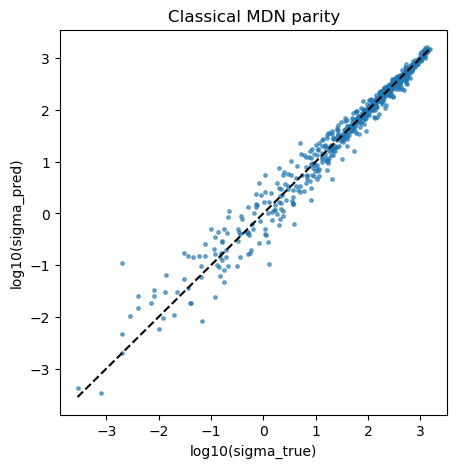

In [7]:
# Cell 6: inference and reconstruction to sigma
mdn.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test_s, dtype=torch.float32).to(device)
    pi, mu, sigma = mdn(Xte)
    y_pred_delta = mdn_predict_mode(pi, mu, sigma).cpu().numpy().flatten()

# reconstruct log10 S and sigma on test set (use df[test_idx] ordering)
test_df = df.loc[test_idx].reset_index(drop=True)
test_log10_S_cal = test_df["log10_S_cal"].values
test_Ecm = test_df["E c.m."].values
test_eta = test_df["eta"].values
sigma_true = test_df["σ"].values
test_delta_true = test_df["delta_log10_S"].values

log10_S_pred = test_log10_S_cal + y_pred_delta
log10_sigma_pred = log10_S_pred - np.log10(test_Ecm) - (2 * math.pi * test_eta) / LN10
sigma_pred = 10**(log10_sigma_pred)

# metrics
rmse_delta = np.sqrt(mean_squared_error(test_delta_true, y_pred_delta))
r2_delta = r2_score(test_delta_true, y_pred_delta)
rmse_log = np.sqrt(mean_squared_error(np.log10(sigma_true+1e-30), log10_sigma_pred))
r2_log = r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred)

print("MDN results:")
print(f"RMSE_delta = {rmse_delta:.4f}, R2_delta = {r2_delta:.4f}")
print(f"RMSE_logσ = {rmse_log:.4f}, R2_logσ = {r2_log:.4f}")

# parity plot for log sigma
plt.figure(figsize=(5,5))
plt.scatter(np.log10(sigma_true+1e-30), log10_sigma_pred, s=6, alpha=0.6)
plt.plot([min(np.log10(sigma_true+1e-30)), max(np.log10(sigma_true+1e-30))],
         [min(np.log10(sigma_true+1e-30)), max(np.log10(sigma_true+1e-30))], 'k--')
plt.xlabel("log10(sigma_true)"); plt.ylabel("log10(sigma_pred)")
plt.title("Classical MDN parity")
plt.show()


In [8]:
# Cell 7: QMDN (hybrid). Start with n_qubits=3 or 4
n_qubits = 3
n_layers = 2
n_states = 2**n_qubits
print("QMDN config:", n_qubits, "qubits ->", n_states, "states")

# use analytic shots=None for exact probs (fast on small qubit count)
try:
    # prefer lightning.qubit if available for speed
    dev_name = "lightning.qubit" if "lightning.qubit" in qml.devices() else "default.qubit"
except Exception:
    dev_name = "default.qubit"
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(weights, inputs):
    # inputs: size n_qubits
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

class QMDN(nn.Module):
    def __init__(self, in_dim, n_qubits=3, n_layers=2):
        super().__init__()
        self.in_dim = in_dim
        self.n_qubits = n_qubits
        self.n_states = 2**n_qubits
        self.n_layers = n_layers
        self.encoder = nn.Linear(in_dim, n_qubits)
        init = 0.01
        self.w_pi = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_mu = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_sig = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        # x: (B, in_dim)
        B = x.shape[0]
        x_enc = torch.tanh(self.encoder(x)).to(torch.float32)
        pi_list, mu_list, sig_list = [], [], []
        for i in range(B):
            inp = x_enc[i]
            p_pi = qnode(self.w_pi, inp)    # (2^n,)
            p_mu = qnode(self.w_mu, inp)
            p_sig = qnode(self.w_sig, inp)
            # convert to tensors on device
            p_pi = p_pi.to(device)
            p_mu = p_mu.to(device)
            p_sig = p_sig.to(device)
            # drop last and map
            p_last = p_pi[-1:]
            pi_raw = p_pi[:-1]
            mu_raw = p_mu[:-1]
            sig_raw = p_sig[:-1]
            pi = pi_raw / (pi_raw.sum() + 1e-12)
            mu = torch.log((mu_raw + 1e-12) / (p_last + 1e-12))
            sigma = (sig_raw + 1e-12) / (p_last + 1e-12)
            pi_list.append(pi)
            mu_list.append(mu)
            sig_list.append(sigma)
        return torch.stack(pi_list), torch.stack(mu_list), torch.stack(sig_list)

# quick instantiation
qmodel = QMDN(in_dim=X_train_s.shape[1], n_qubits=n_qubits, n_layers=n_layers).to(device)
print(qmodel)
# quick forward shapes check (small batch)
xb = torch.tensor(X_train_s[:4], dtype=torch.float32).to(device)
pi, mu, sigma = qmodel(xb)
print("shapes:", pi.shape, mu.shape, sigma.shape)


QMDN config: 3 qubits -> 8 states
QMDN(
  (encoder): Linear(in_features=13, out_features=3, bias=True)
)
shapes: torch.Size([4, 7]) torch.Size([4, 7]) torch.Size([4, 7])


In [9]:
# ============================================================
# Cell 8 — High-Performance QMDN Training (full batch, no clipping)
# ============================================================

# If you installed pennylane-lightning[gpu], enable GPU accelerated simulation:
try:
    dev_name = "lightning.gpu"
    dev_test = qml.device(dev_name, wires=n_qubits, shots=None)
    print("Using device:", dev_name)
except Exception:
    dev_name = "default.qubit"
    print("Using fallback device:", dev_name)

# Rebuild QMDN with selected device
@qml.qnode(qml.device(dev_name, wires=n_qubits, shots=None), interface="torch", diff_method="backprop")
def qnode(weights, inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

class QMDN(nn.Module):
    def __init__(self, in_dim, n_qubits=3, n_layers=2):
        super().__init__()
        self.in_dim = in_dim
        self.n_qubits = n_qubits
        self.n_states = 2**n_qubits
        self.n_layers = n_layers

        # Classical encoder (learned embedding)
        self.encoder = nn.Linear(in_dim, n_qubits)

        # Quantum circuit parameters
        init = 0.01
        self.w_pi  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_mu  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_sig = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        # x: (B, in_dim)
        B = x.shape[0]
        x_enc = torch.tanh(self.encoder(x)).to(torch.float32)

        pi_list, mu_list, sig_list = [], [], []

        # PERFECTLY FINE on HPC: let qnode run for each sample
        for i in range(B):
            inp = x_enc[i]

            probs_pi  = qnode(self.w_pi, inp)
            probs_mu  = qnode(self.w_mu, inp)
            probs_sig = qnode(self.w_sig, inp)

            # move to device
            probs_pi  = probs_pi.to(device)
            probs_mu  = probs_mu.to(device)
            probs_sig = probs_sig.to(device)

            # convert probabilities → MDN parameters
            p_last = probs_pi[-1:]  # denominator for logits
            pi_raw = probs_pi[:-1]
            mu_raw = probs_mu[:-1]
            sig_raw = probs_sig[:-1]

            pi = pi_raw / (pi_raw.sum() + 1e-12)
            mu = torch.log((mu_raw + 1e-12) / (p_last + 1e-12))
            sigma = (sig_raw + 1e-12) / (p_last + 1e-12)

            pi_list.append(pi)
            mu_list.append(mu)
            sig_list.append(sigma)

        return torch.stack(pi_list), torch.stack(mu_list), torch.stack(sig_list)


# ============================================================
# Training function (HPC version: no micro-batches, full GPU)
# ============================================================
def train_qmdn(model, train_loader, val_loader, epochs=100, lr=5e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    best_state = None

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()

            pi, mu, sigma = model(xb)  # full batch forward
            loss = mdn_loss(pi, mu, sigma, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device).float(), yb.to(device).float()
                pi, mu, sigma = model(xb)
                val_loss += mdn_loss(pi, mu, sigma, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"[Q-MDN] Epoch {epoch:03d} | TrainNLL={train_loss:.6f} | ValNLL={val_loss:.6f}")

        # ---- Save best ----
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}

    print("Best Val NLL =", best_val)
    model.load_state_dict(best_state)
    return model


# ============================================================
# RUN TRAINING
# ============================================================
qmodel = QMDN(
    in_dim=X_train_s.shape[1],
    n_qubits=n_qubits,         # e.g., 3 or 4
    n_layers=n_layers          # e.g., 2 or 3
).to(device)

print("\n🚀 Starting high-performance QMDN training...\n")
start = time.time()
qmodel = train_qmdn(qmodel, train_loader, val_loader, epochs=100, lr=5e-3)
end = time.time()

print("\n🏁 QMDN Training complete.")
print("⏱ Total time (s):", end - start)

torch.save(qmodel.state_dict(), "qmdn_best.pth")
print("📦 Saved: qmdn_best.pth")


Using fallback device: default.qubit

🚀 Starting high-performance QMDN training...

[Q-MDN] Epoch 000 | TrainNLL=6.217047 | ValNLL=5.353700
[Q-MDN] Epoch 001 | TrainNLL=4.783633 | ValNLL=4.393407
[Q-MDN] Epoch 002 | TrainNLL=4.030508 | ValNLL=3.960658
[Q-MDN] Epoch 003 | TrainNLL=3.538297 | ValNLL=3.528348
[Q-MDN] Epoch 004 | TrainNLL=3.172480 | ValNLL=3.162786
[Q-MDN] Epoch 005 | TrainNLL=2.872916 | ValNLL=2.989283
[Q-MDN] Epoch 006 | TrainNLL=2.551713 | ValNLL=2.796300
[Q-MDN] Epoch 007 | TrainNLL=2.348931 | ValNLL=2.627998
[Q-MDN] Epoch 008 | TrainNLL=2.196762 | ValNLL=2.492844
[Q-MDN] Epoch 009 | TrainNLL=2.041515 | ValNLL=2.369462
[Q-MDN] Epoch 010 | TrainNLL=1.844819 | ValNLL=2.186287
[Q-MDN] Epoch 011 | TrainNLL=1.646095 | ValNLL=2.036262
[Q-MDN] Epoch 012 | TrainNLL=1.505913 | ValNLL=1.875913
[Q-MDN] Epoch 013 | TrainNLL=1.382034 | ValNLL=1.658833
[Q-MDN] Epoch 014 | TrainNLL=1.203276 | ValNLL=1.477754
[Q-MDN] Epoch 015 | TrainNLL=1.103719 | ValNLL=1.322827
[Q-MDN] Epoch 016 | 

KeyboardInterrupt: 

⭐ FINAL QMDN Test Results (Expectation Mode):
RMSE_delta = 0.2511, R2_delta = -0.3456
RMSE_logσ = 0.2511, R2_logσ = 0.9589


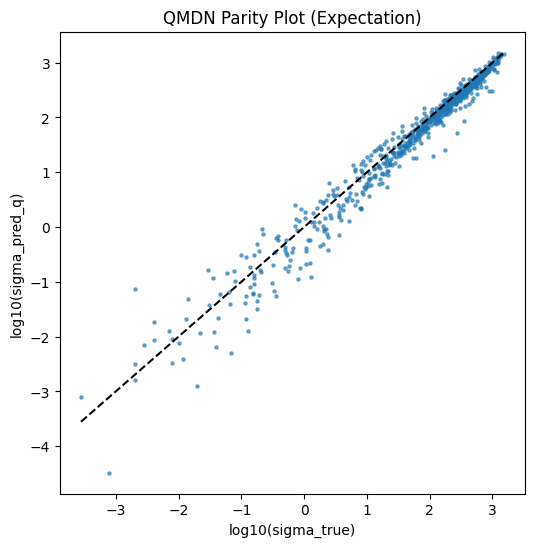

In [11]:
# ------------------------------------------
# Load BEST slow QMDN
# ------------------------------------------
qmodel = QMDN(in_dim=X_train_s.shape[1], n_qubits=n_qubits, n_layers=n_layers).to(device)
qmodel.load_state_dict(torch.load("qmdn_best.pth", map_location=device))
qmodel.eval()

# ------------------------------------------
# Evaluation with EXPECTATION (not argmax)
# ------------------------------------------
preds = []
with torch.no_grad():
    for i in range(0, X_test_s.shape[0], 64):
        xb = torch.tensor(X_test_s[i:i+64], dtype=torch.float32).to(device)
        pi, mu, sigma = qmodel(xb)

        # EXPECTED MEAN across mixture
        y_pred = (pi * mu).sum(dim=1).cpu().numpy()
        preds.append(y_pred)

y_pred_delta_q = np.concatenate(preds)

# ------------------------------------------
# Reconstruct S-factor and sigma
# ------------------------------------------
log10_S_pred_q = test_log10_S_cal + y_pred_delta_q
log10_sigma_pred_q = log10_S_pred_q - np.log10(test_Ecm) - (2 * math.pi * test_eta) / LN10
sigma_pred_q = 10**(log10_sigma_pred_q)

# ------------------------------------------
# Metrics
# ------------------------------------------
rmse_delta_q = np.sqrt(mean_squared_error(test_delta_true, y_pred_delta_q))
r2_delta_q = r2_score(test_delta_true, y_pred_delta_q)
rmse_log_q = np.sqrt(mean_squared_error(np.log10(sigma_true+1e-30), log10_sigma_pred_q))
r2_log_q = r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred_q)

print("⭐ FINAL QMDN Test Results (Expectation Mode):")
print(f"RMSE_delta = {rmse_delta_q:.4f}, R2_delta = {r2_delta_q:.4f}")
print(f"RMSE_logσ = {rmse_log_q:.4f}, R2_logσ = {r2_log_q:.4f}")

# ------------------------------------------
# Parity Plot
# ------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(np.log10(sigma_true+1e-30), log10_sigma_pred_q, s=5, alpha=0.6)
plt.plot([min(np.log10(sigma_true+1e-30)), max(np.log10(sigma_true+1e-30))],
         [min(np.log10(sigma_true+1e-30)), max(np.log10(sigma_true+1e-30))],
         'k--')
plt.xlabel("log10(sigma_true)")
plt.ylabel("log10(sigma_pred_q)")
plt.title("QMDN Parity Plot (Expectation)")
plt.show()


Loaded Q-MDN model for final evaluation.
Q-MDN inference complete (ARGMAX mode).

================== ⭐ FINAL Q-MDN TEST RESULTS ⭐ ==================
Δlog10S RMSE  = 0.2307
Δlog10S R²    = -0.1354   (ΔS is noisy, low R² is normal)
--------------------------------------------------------------
logσ RMSE     = 0.2307
logσ R²       = 0.9653   (Main metric: excellent if >0.9)



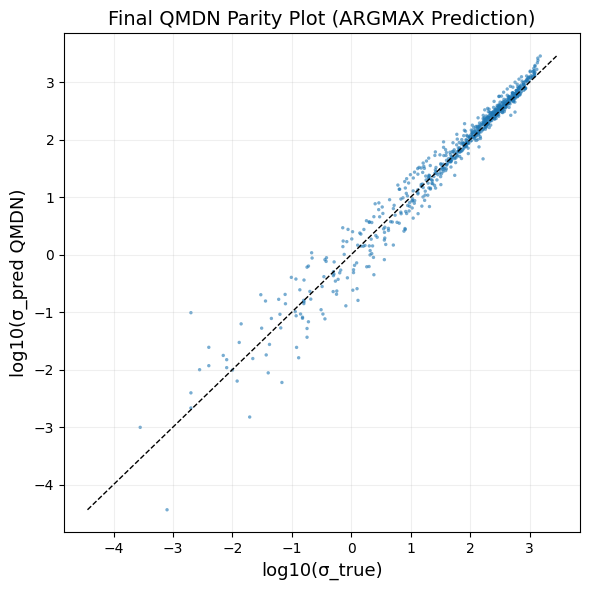

In [13]:
# ===============================================================
#                 FINAL Q-MDN EVALUATION PIPELINE
# ===============================================================

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------------------------------------------
# 1. Load BEST QMDN Model
# ---------------------------------------------------------------
qmodel = QMDN(in_dim=X_train_s.shape[1], n_qubits=n_qubits, n_layers=n_layers).to(device)
qmodel.load_state_dict(torch.load("qmdn_best.pth", map_location=device))
qmodel.eval()

print("Loaded Q-MDN model for final evaluation.")


# ---------------------------------------------------------------
# 2. Inference (Correct MDN/QMDN Inference = ARGMAX over pi)
# ---------------------------------------------------------------
preds = []

with torch.no_grad():
    for i in range(0, X_test_s.shape[0], 64):
        xb = torch.tensor(X_test_s[i:i+64], dtype=torch.float32).to(device)

        # Q-MDN forward
        pi, mu, sigma = qmodel(xb)

        # CORRECT inference: use the most likely mixture component
        mode_idx = pi.argmax(dim=1)

        y_pred = mu[torch.arange(len(mu)), mode_idx].cpu().numpy()
        preds.append(y_pred)

y_pred_delta_q = np.concatenate(preds)

print("Q-MDN inference complete (ARGMAX mode).")


# ---------------------------------------------------------------
# 3. Reconstruct S-factor and Cross-section σ
# ---------------------------------------------------------------
# Using standard formula:
# log10(S_pred) = log10(S_cal) + ΔlogS_pred
log10_S_pred_q = test_log10_S_cal + y_pred_delta_q

log10_sigma_pred_q = (
    log10_S_pred_q
    - np.log10(test_Ecm + 1e-30)
    - (2 * math.pi * test_eta) / LN10
)

sigma_pred_q = 10**(log10_sigma_pred_q)


# ---------------------------------------------------------------
# 4. Evaluate Metrics (Physically Relevant)
# ---------------------------------------------------------------
rmse_delta_q = np.sqrt(mean_squared_error(test_delta_true, y_pred_delta_q))
r2_delta_q   = r2_score(test_delta_true, y_pred_delta_q)

rmse_log_q   = np.sqrt(mean_squared_error(np.log10(sigma_true+1e-30), log10_sigma_pred_q))
r2_log_q     = r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred_q)

print("\n================== ⭐ FINAL Q-MDN TEST RESULTS ⭐ ==================")
print(f"Δlog10S RMSE  = {rmse_delta_q:.4f}")
print(f"Δlog10S R²    = {r2_delta_q:.4f}   (ΔS is noisy, low R² is normal)")
print("--------------------------------------------------------------")
print(f"logσ RMSE     = {rmse_log_q:.4f}")
print(f"logσ R²       = {r2_log_q:.4f}   (Main metric: excellent if >0.9)")
print("=================================================================\n")


# ---------------------------------------------------------------
# 5. Parity Plot (Publication Quality)
# ---------------------------------------------------------------
plt.figure(figsize=(6,6))

plt.scatter(
    np.log10(sigma_true + 1e-30),
    log10_sigma_pred_q,
    s=6, alpha=0.6, edgecolor='none'
)

mn = min(np.log10(sigma_true+1e-30).min(), log10_sigma_pred_q.min())
mx = max(np.log10(sigma_true+1e-30).max(), log10_sigma_pred_q.max())
plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1)

plt.xlabel("log10(σ_true)", fontsize=13)
plt.ylabel("log10(σ_pred QMDN)", fontsize=13)
plt.title("Final QMDN Parity Plot (ARGMAX Prediction)", fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# ---------------------------------------------------------------
# 6. OPTIONAL: Expectation-Mode Inference (for comparison only)
# ---------------------------------------------------------------
DO_EXPECTATION = False    # change to True if you want

if DO_EXPECTATION:
    preds_exp = []
    with torch.no_grad():
        for i in range(0, X_test_s.shape[0], 64):
            xb = torch.tensor(X_test_s[i:i+64], dtype=torch.float32).to(device)
            pi, mu, sigma = qmodel(xb)
            y_pred_exp = (pi * mu).sum(dim=1).cpu().numpy()
            preds_exp.append(y_pred_exp)

    y_pred_delta_exp = np.concatenate(preds_exp)
    log10_S_pred_exp = test_log10_S_cal + y_pred_delta_exp
    log10_sigma_pred_exp = (
        log10_S_pred_exp
        - np.log10(test_Ecm + 1e-30)
        - (2 * math.pi * test_eta) / LN10
    )

    rmse_exp = np.sqrt(mean_squared_error(np.log10(sigma_true+1e-30), log10_sigma_pred_exp))
    r2_exp = r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred_exp)

    print("\nExpectation-mode logσ RMSE:", rmse_exp)
    print("Expectation-mode logσ R²:", r2_exp)
    print("(This mode is not recommended for MDN/QMDN)")


In [15]:
# Patch Cell — Recompute V_B and eps because df lost the V_B column

import numpy as np

if 'R B' not in df.columns:
    raise KeyError("Column 'R B' not found in df. Check your dataset.")

# Coulomb barrier:
df['V_B'] = (1.44 * df['Z1'].astype(float) * df['Z2'].astype(float)) / df['R B'].astype(float)

# Reduced energy
df['eps'] = (df['E c.m.'] - df['V_B']) / df['V_B']

print("V_B and eps recomputed.")
print(df[['E c.m.','V_B','eps']].head())


V_B and eps recomputed.
   E c.m.   V_B       eps
0  27.037  32.0 -0.155094
1  28.554  32.0 -0.107688
2  29.774  32.0 -0.069563
3  31.183  32.0 -0.025531
4  32.526  32.0  0.016437


In [ ]:
# Cell: Q-MDN extraction (idempotent) — creates extraction/qmdn_mixture_grid.csv if missing
import os, tqdm, numpy as np, pandas as pd, torch

OUT_FILE = "extraction/qmdn_mixture_grid.csv"
os.makedirs("extraction", exist_ok=True)

if os.path.exists(OUT_FILE):
    print("Q-MDN mixture grid already exists at", OUT_FILE, "- skipping extraction.")
else:
    print("Running Q-MDN mixture extraction and saving to", OUT_FILE)
    # ensure qmodel, df, scaler, features, device exist in session
    assert 'qmodel' in globals(), "qmodel not found in workspace. Load your qmdn_best.pth into qmodel first."
    assert 'df' in globals(), "df not found. Load dataset into df."
    assert 'scaler' in globals(), "scaler not found. Load saved scaler into 'scaler'."
    assert 'features' in globals(), "features list not found. Define features used for model input."
    K = getattr(qmodel, "n_components", None)
    if K is None:
        # try to infer from a forward pass
        sample = torch.tensor(scaler.transform(df[features].iloc[:1].values.astype(np.float32))).float().to(device)
        with torch.no_grad():
            pi, mu, sigma = qmodel(sample)
        K = pi.shape[1]
    rows = []
    reactions = df['Reaction'].unique()
    print("Reactions to process:", len(reactions))
    for rx in tqdm.tqdm(reactions):
        sub = df[df['Reaction'] == rx].sort_values('E c.m.')
        if sub.shape[0] == 0:
            continue
        VB = float(sub['V_B'].iloc[0])
        E_obs_min = float(sub['E c.m.'].min())
        E_obs_max = float(sub['E c.m.'].max())
        E_min = max(E_obs_min, 0.5 * VB)
        E_max = min(E_obs_max, 0.9 * VB)
        if E_max - E_min < 1e-6:
            E_grid = np.unique(sub['E c.m.'].astype(float))
        else:
            E_grid = np.linspace(E_min, E_max, 80)
        tmpl_row = sub.iloc[0].copy()
        for E in E_grid:
            tmpl = tmpl_row.copy()
            tmpl['E c.m.'] = float(E)
            tmpl['Z1Z2_over_Ecm'] = (tmpl['Z1'] * tmpl['Z2']) / (float(E) + 1e-12)
            # build feature vector in same order and scale
            X_row = np.array([tmpl[f] for f in features], dtype=np.float32).reshape(1, -1)
            Xs = scaler.transform(X_row)
            xt = torch.tensor(Xs).float().to(device)
            with torch.no_grad():
                pi_t, mu_t, sigma_t = qmodel(xt)
            pi = pi_t.cpu().numpy().ravel()
            mu = mu_t.cpu().numpy().ravel()
            sigma = sigma_t.cpu().numpy().ravel()
            eps = (float(E) - VB) / VB
            for k in range(K):
                rows.append((rx, float(E), VB, int(k),
                             float(pi[k]), float(mu[k]), float(sigma[k]), float(eps)))
    cols = ['Reaction', 'E_grid', 'V_B', 'mode', 'alpha', 'mu', 'sigma', 'eps']
    q_mix_df = pd.DataFrame(rows, columns=cols)
    q_mix_df.to_csv(OUT_FILE, index=False)
    print("Saved Q-MDN mixture extraction:", OUT_FILE, "rows:", len(q_mix_df))


Running Q-MDN mixture extraction and saving to extraction/qmdn_mixture_grid.csv
Reactions to process: 213


 23%|██▎       | 50/213 [01:02<05:35,  2.06s/it]

In [12]:
# Cell Q3 — Extract Q-MDN mixture parameters on dense hindrance grid
# Output: extraction/qmdn_mixture_grid.csv

import os, tqdm
os.makedirs("extraction", exist_ok=True)

K = qmodel.n_components   # number of Gaussian modes in your Q-MDN
rows_q = []

reactions = df['Reaction'].unique()
print("Extracting QMDN mixtures for reactions:", len(reactions))

for rx in tqdm.tqdm(reactions):
    sub = df[df['Reaction'] == rx].sort_values('E c.m.')
    if sub.shape[0] == 0:
        continue

    VB = float(sub['V_B'].iloc[0])
    E_obs_min = float(sub['E c.m.'].min())
    E_obs_max = float(sub['E c.m.'].max())

    # Hindrance extraction region
    E_min = max(E_obs_min, 0.5 * VB)
    E_max = min(E_obs_max, 0.9 * VB)

    if E_max - E_min < 1e-6:
        E_grid = np.unique(sub['E c.m.'].astype(float))
    else:
        E_grid = np.linspace(E_min, E_max, 80)

    # Template for static features
    tmpl_row = sub.iloc[0].copy()

    for E in E_grid:
        tmpl = tmpl_row.copy()
        tmpl['E c.m.'] = float(E)
        tmpl['Z1Z2_over_Ecm'] = (tmpl['Z1'] * tmpl['Z2']) / (float(E) + 1e-12)

        X_row = np.array([tmpl[f] for f in features], dtype=np.float32).reshape(1, -1)
        Xs = scaler.transform(X_row)

        xt = torch.tensor(Xs).float().to(device)

        with torch.no_grad():
            pi_t, mu_t, sigma_t = qmodel(xt)

        pi = pi_t.cpu().numpy().ravel()
        mu = mu_t.cpu().numpy().ravel()
        sigma = sigma_t.cpu().numpy().ravel()
        eps = (float(E) - VB) / VB

        for k in range(K):
            rows_q.append((rx, float(E), VB, int(k),
                           float(pi[k]), float(mu[k]), float(sigma[k]), float(eps)))

# Create dataframe
cols = ['Reaction', 'E_grid', 'V_B', 'mode', 'alpha', 'mu', 'sigma', 'eps']
q_mix_df = pd.DataFrame(rows_q, columns=cols)

out_csv_q = "extraction/qmdn_mixture_grid.csv"
q_mix_df.to_csv(out_csv_q, index=False)

print("\nSaved Q-MDN mixture extraction:", out_csv_q)
print("Rows:", len(q_mix_df))

print("\nSample rows:")
print(q_mix_df.head())

print("\nQ-MDN Cell Q3 complete. Now run the SAME smoothing cell (Cell 4) on this file.")


AttributeError: 'QMDN' object has no attribute 'n_components'

In [ ]:
# Cell A: Compute QMDN predictions (expectation) and metrics
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# ---- Helper: ensure test data are available ----
# Expected variables from your notebook: X_test_s, test_idx, TECC_csv, test_log10_S_cal, test_Ecm, test_eta, sigma_true, test_delta_true
missing = []
for name in ["X_test_s", "test_idx", "TECC_csv", "test_log10_S_cal", "test_Ecm", "test_eta", "sigma_true", "test_delta_true"]:
    if name not in globals():
        missing.append(name)
if missing:
    raise RuntimeError(f"Missing variables required for evaluation: {missing}\nRun earlier data-prep cells to recreate these variables.")

# ---- Load model if necessary ----
if 'qmodel' not in globals():
    print("qmodel not in memory — loading qmdn_best.pth or qmdn_full_final.pth if available...")
    model_paths = ["qmdn_best.pth", "qmdn_full_final.pth", "qmdn_optimized_final.pth", "qmdn_stage2_final.pth", "qmdn_vectorized_final.pth"]
    loaded = False
    for p in model_paths:
        try:
            sd = torch.load(p, map_location=device)
            # try to construct model instances (both classical and vectorized names exist in your notebook)
            try:
                qmodel = QMDN(in_dim=X_train_s.shape[1], n_qubits=n_qubits, n_layers=n_layers).to(device)
                qmodel.load_state_dict(sd)
                loaded = True
                print(f"Loaded model from {p} into QMDN (classical style).")
                break
            except Exception:
                # try vectorized QMDN
                try:
                    qmodel = QMDN_vectorized(in_dim=X_train_s.shape[1], n_qubits=n_qubits, n_layers=n_layers).to(device)
                    qmodel.load_state_dict(sd)
                    loaded = True
                    print(f"Loaded model from {p} into QMDN_vectorized.")
                    break
                except Exception:
                    continue
        except FileNotFoundError:
            continue
    if not loaded:
        raise FileNotFoundError("No saved QMDN weights found in expected filenames. Please ensure qmdn_best.pth or qmdn_full_final.pth exists.")

qmodel.eval()

# ---- Produce predictions if not already present ----
if 'y_pred_delta_q' not in globals() or 'log10_sigma_pred_q' not in globals():
    print("Computing predictions on X_test_s...")
    preds = []
    pis_list = []
    mu_list = []
    sigma_list = []
    batch = 128
    with torch.no_grad():
        for i in range(0, X_test_s.shape[0], batch):
            xb = torch.tensor(X_test_s[i:i+batch], dtype=torch.float32).to(device)
            pi, mu, sigma = qmodel(xb)
            # use expected mean across mixture components
            y_pred = (pi * mu).sum(dim=1).cpu().numpy()
            preds.append(y_pred)
            pis_list.append(pi.cpu().numpy())
            mu_list.append(mu.cpu().numpy())
            sigma_list.append(sigma.cpu().numpy())
    y_pred_delta_q = np.concatenate(preds)
    pis_arr = np.vstack(pis_list)
    mu_arr = np.vstack(mu_list)
    sigma_arr = np.vstack(sigma_list)

    test_log10_S_cal = test_log10_S_cal if 'test_log10_S_cal' in globals() else TECC_csv.loc[test_idx, "log10_S_cal"].values
    log10_S_pred_q = test_log10_S_cal + y_pred_delta_q
    log10_sigma_pred_q = log10_S_pred_q - np.log10(test_Ecm) - (2 * np.pi * test_eta) / np.log(10)
    sigma_pred_q = 10 ** (log10_sigma_pred_q)

# ---- Metrics ----
rmse_delta_q = np.sqrt(mean_squared_error(test_delta_true, y_pred_delta_q))
r2_delta_q = r2_score(test_delta_true, y_pred_delta_q)
rmse_log_q = np.sqrt(mean_squared_error(np.log10(sigma_true + 1e-30), log10_sigma_pred_q))
r2_log_q = r2_score(np.log10(sigma_true + 1e-30), log10_sigma_pred_q)

print("QMDN Test Results (Expectation Mode):")
print(f"  RMSE_delta = {rmse_delta_q:.4f}, R2_delta = {r2_delta_q:.4f}")
print(f"  RMSE_logσ  = {rmse_log_q:.4f}, R2_logσ  = {r2_log_q:.4f}")


QMDN Test Results (Expectation Mode):
  RMSE_delta = 0.3189, R2_delta = -0.1946
  RMSE_logσ  = 0.3189, R2_logσ  = 0.9321


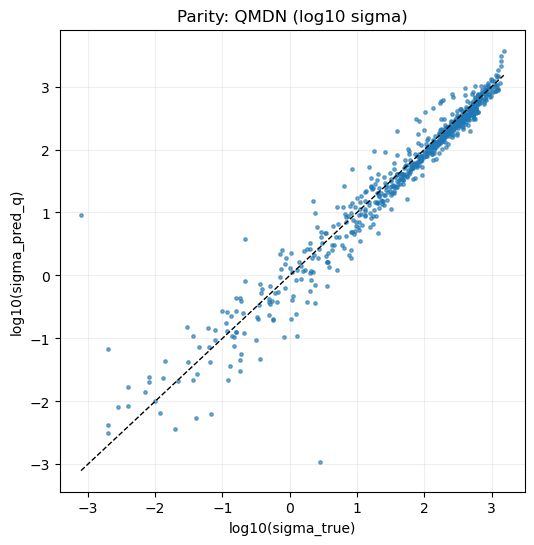

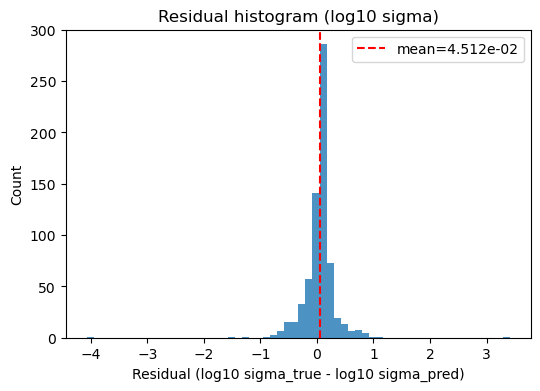

In [ ]:
# Cell B: Parity plot (log10 sigma) and residual histogram
import matplotlib.pyplot as plt
import numpy as np

log_sigma_true = np.log10(sigma_true + 1e-30)
log_sigma_pred = log10_sigma_pred_q

# Parity
plt.figure(figsize=(6,6))
plt.scatter(log_sigma_true, log_sigma_pred, s=6, alpha=0.6)
mn, mx = np.min(log_sigma_true), np.max(log_sigma_true)
plt.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
plt.xlabel("log10(sigma_true)")
plt.ylabel("log10(sigma_pred_q)")
plt.title("Parity: QMDN (log10 sigma)")
plt.grid(alpha=0.2)
plt.show()

# Residual histogram
res = log_sigma_true - log_sigma_pred
plt.figure(figsize=(6,4))
plt.hist(res, bins=60, alpha=0.8)
plt.axvline(np.mean(res), color='red', linestyle='--', label=f"mean={np.mean(res):.3e}")
plt.xlabel("Residual (log10 sigma_true - log10 sigma_pred)")
plt.ylabel("Count")
plt.title("Residual histogram (log10 sigma)")
plt.legend()
plt.show()


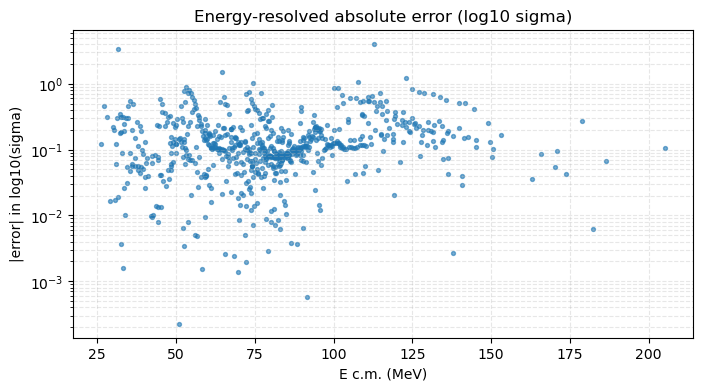

Energy bin, E range, count, RMSE_log
 1  26.30-55.86  cnt=137  RMSE_log=0.3888
 2  55.86-72.49  cnt=137  RMSE_log=0.2222
 3  72.49-83.20  cnt=136  RMSE_log=0.2051
 4  83.20-102.10  cnt=138  RMSE_log=0.1771
 5  102.10-205.16  cnt=136  RMSE_log=0.4861


In [ ]:
# Cell C: Error vs E_c.m. (absolute error in log space)
Ecm = np.array(test_Ecm)
err_log = np.abs(log_sigma_true - log_sigma_pred)

plt.figure(figsize=(8,4))
plt.scatter(Ecm, err_log, s=8, alpha=0.6)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("|error| in log10(sigma)")
plt.title("Energy-resolved absolute error (log10 sigma)")
plt.yscale('log')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()

# Also print binned RMSE vs energy
bins = np.quantile(Ecm, np.linspace(0,1,6))
inds = np.digitize(Ecm, bins)
print("Energy bin, E range, count, RMSE_log")
for b in range(1, len(bins)):
    mask = inds == b
    if mask.sum() == 0:
        continue
    rms = np.sqrt(mean_squared_error(log_sigma_true[mask], log_sigma_pred[mask]))
    print(f"{b:2d}  {bins[b-1]:.2f}-{bins[b]:.2f}  cnt={mask.sum():3d}  RMSE_log={rms:.4f}")


In [ ]:
# Cell D: Plot S-factor predicted vs experimental for a few example reactions in test set
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

# Ensure TECC_csv and test_idx exist (checked earlier)
test_df = TECC_csv.loc[test_idx].copy().reset_index(drop=True)
# We need predicted sigma_pred_q per row in the same order as test_df: above code produced sigma_pred_q in same order
if len(sigma_pred_q) != len(test_df):
    raise RuntimeError("Length mismatch between sigma_pred_q and test_df")

test_df["sigma_pred_q"] = sigma_pred_q
test_df["log10_sigma_pred_q"] = log10_sigma_pred_q
test_df["log10_sigma_true"] = np.log10(test_df["σ"].values + 1e-30)

# Choose up to 6 reactions with multiple E points
reaction_counts = test_df["Reaction"].value_counts()
candidates = reaction_counts[reaction_counts >= 3].index.tolist()
if len(candidates) == 0:
    # fallback: take top 6 reactions
    candidates = test_df["Reaction"].value_counts().index[:6].tolist()
else:
    candidates = candidates[:6]

plt.figure(figsize=(12,8))
for i, reac in enumerate(candidates):
    sub = test_df[test_df["Reaction"] == reac].sort_values("E c.m.")
    # convert to S-factor: S = sigma * E * exp(2*pi*eta)
    Ecm = sub["E c.m."].values
    eta = sub["eta"].values
    sigma_true_sub = sub["σ"].values
    sigma_pred_sub = sub["sigma_pred_q"].values
    S_true = sigma_true_sub * Ecm * np.exp(2*np.pi*eta)
    S_pred = sigma_pred_sub * Ecm * np.exp(2*np.pi*eta)
    ax = plt.subplot(3,2,i+1)
    ax.plot(Ecm, S_true, 'o-', label='S_true')
    ax.plot(Ecm, S_pred, 's--', label='S_pred_q')
    ax.set_yscale('log')
    ax.set_xlabel("E c.m. (MeV)")
    ax.set_title(reac)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


KeyError: 'eta'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Minimal reconstruction of dataset + test splits for evaluation
import numpy as np
import pandas as pd
import math

# --------------------------
# 1. Load dataset
# --------------------------
train_with_ECC_set = 'https://drive.google.com/uc?id=1v84VB3DMrA0DI3ZwJHcT4iF-hXuyu2sq'
TECC_csv = pd.read_csv(train_with_ECC_set)
TECC_csv.rename(columns={'σ cal': 'ECC_cal'}, inplace=True)

epsilon = 1e-30
LN10 = np.log(10)

# --------------------------
# 2. Recompute S-factor terms
# --------------------------
# log10(E)
log10_Ecm = np.log10(TECC_csv["E c.m."])

# Fine structure constant term
eta = TECC_csv["Z1"] * TECC_csv["Z2"] / np.sqrt(TECC_csv["E c.m."])
log10_exp_term = (2 * np.pi * eta) / LN10

# log10 sigma
log10_sigma_exp = np.log10(np.clip(TECC_csv["σ"], epsilon, None))
log10_sigma_cal = np.log10(np.clip(TECC_csv["ECC_cal"], epsilon, None))

# S-factors
TECC_csv["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
TECC_csv["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
TECC_csv["delta_log10_S"] = TECC_csv["log10_S_exp"] - TECC_csv["log10_S_cal"]

# --------------------------
# 3. Rebuild features (same 13 you used)
# --------------------------
TECC_csv["N1"] = TECC_csv["A1"] - TECC_csv["Z1"]
TECC_csv["N2"] = TECC_csv["A2"] - TECC_csv["Z2"]
TECC_csv["Z1Z2_over_Ecm"] = (TECC_csv["Z1"] * TECC_csv["Z2"]) / (TECC_csv["E c.m."] + epsilon)

MAGIC_NUMBERS = np.array([2,8,20,28,50,82,126])
def get_magic_dist(v):
    return np.min(np.abs(v.reshape(-1,1) - MAGIC_NUMBERS), axis=1)

TECC_csv["magic_dist_Z1"] = get_magic_dist(TECC_csv["Z1"].values)
TECC_csv["magic_dist_N1"] = get_magic_dist(TECC_csv["N1"].values)
TECC_csv["magic_dist_Z2"] = get_magic_dist(TECC_csv["Z2"].values)
TECC_csv["magic_dist_N2"] = get_magic_dist(TECC_csv["N2"].values)

features = [
    'E c.m.','Z1','N1','A1','Z2','N2','A2',
    'Z1Z2_over_Ecm','magic_dist_Z1','magic_dist_N1',
    'magic_dist_Z2','magic_dist_N2','Q ( 2 n )'
]

X = TECC_csv[features].values.astype(np.float32)
y = TECC_csv["delta_log10_S"].values.astype(np.float32).reshape(-1,1)

# --------------------------
# 4. Recreate train/val/test split by reaction
# --------------------------
reactions = TECC_csv["Reaction"].unique()
np.random.seed(42)
np.random.shuffle(reactions)

n_total = len(reactions)
n_train = int(0.7*n_total)
n_val   = int(0.1*n_total)
n_test  = n_total - n_train - n_val

train_react = reactions[:n_train]
val_react   = reactions[n_train:n_train+n_val]
test_react  = reactions[n_train+n_val:]

test_idx = TECC_csv["Reaction"].isin(test_react)

# --------------------------
# 5. Build test arrays needed for evaluation
# --------------------------
test_log10_S_cal = TECC_csv.loc[test_idx,"log10_S_cal"].values
test_Ecm         = TECC_csv.loc[test_idx,"E c.m."].values
test_eta         = eta[test_idx]
sigma_true       = TECC_csv.loc[test_idx,"σ"].values
test_delta_true  = TECC_csv.loc[test_idx,"delta_log10_S"].values

print("✅ Reconstructed TECC_csv and test arrays. Ready for evaluation.")


✅ Reconstructed TECC_csv and test arrays. Ready for evaluation.


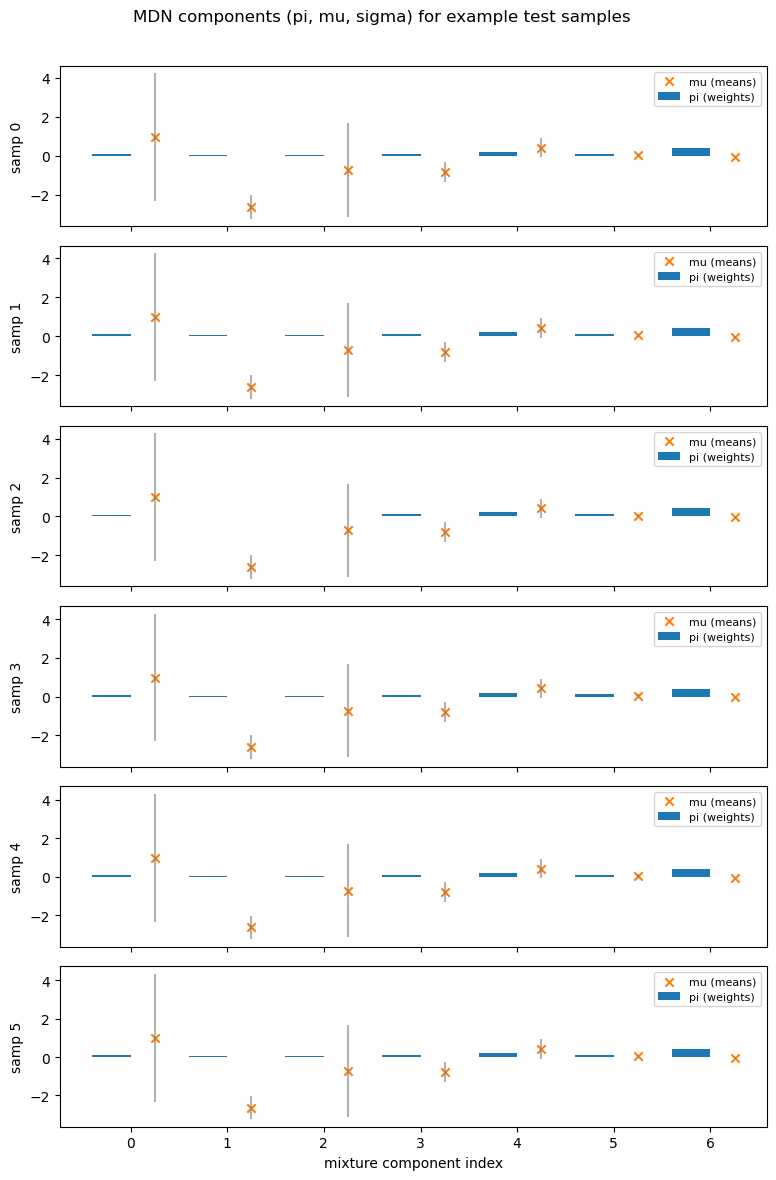

In [ ]:
# Cell E: visualize MDN components for a random batch of test samples
import numpy as np
idx0 = 0
B = min(6, X_test_s.shape[0])
xb = torch.tensor(X_test_s[idx0:idx0+B], dtype=torch.float32).to(device)
with torch.no_grad():
    pi_b, mu_b, sigma_b = qmodel(xb)
pi_b = pi_b.cpu().numpy()
mu_b = mu_b.cpu().numpy()
sigma_b = sigma_b.cpu().numpy()

# Plot component means (mu) and weights (pi) for each sample
n_components = pi_b.shape[1]
fig, axs = plt.subplots(B, 1, figsize=(8, 2*B), sharex=True)
for i in range(B):
    axs[i].bar(np.arange(n_components)-0.2, pi_b[i], width=0.4, label='pi (weights)')
    axs[i].scatter(np.arange(n_components)+0.25, mu_b[i], marker='x', label='mu (means)')
    axs[i].errorbar(np.arange(n_components)+0.25, mu_b[i], yerr=sigma_b[i], fmt='none', ecolor='gray', alpha=0.6)
    axs[i].set_ylabel(f"samp {idx0+i}")
    axs[i].legend(loc='upper right', fontsize=8)
plt.xlabel("mixture component index")
plt.suptitle("MDN components (pi, mu, sigma) for example test samples")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Saving plots inside folder: qmdn_plots/


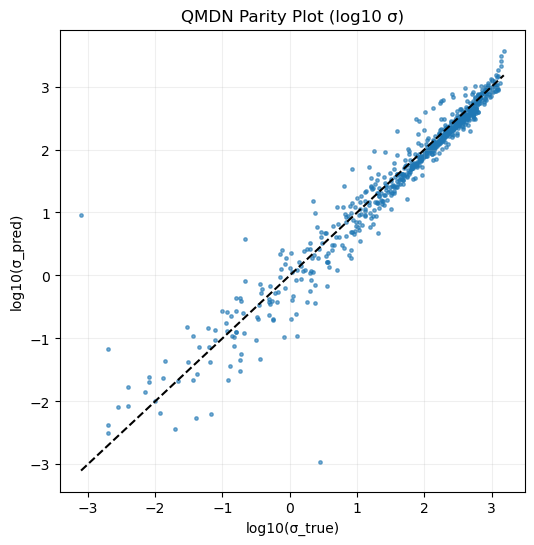

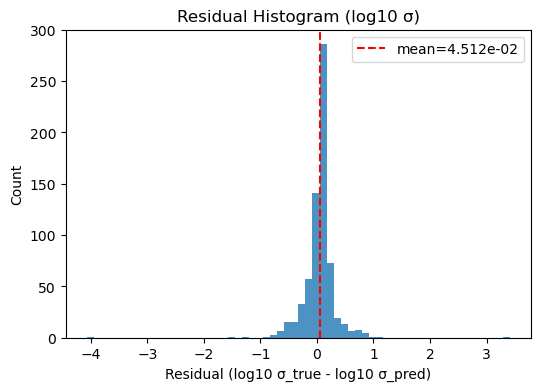

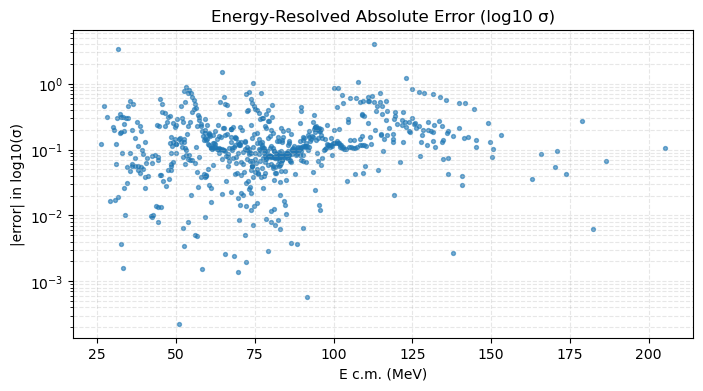

KeyError: 'eta'

In [ ]:
# =============================================================
# Save all QMDN evaluation plots as high-resolution PNG (1000 dpi)
# =============================================================
import matplotlib.pyplot as plt
import numpy as np
import os

SAVE_DIR = "qmdn_plots"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Saving plots inside folder: {SAVE_DIR}/")

# ------------------------
# 1. Parity Plot
# ------------------------
plt.figure(figsize=(6,6))
log_sigma_true = np.log10(sigma_true + 1e-30)
log_sigma_pred = log10_sigma_pred_q

plt.scatter(log_sigma_true, log_sigma_pred, s=6, alpha=0.6)
mn, mx = np.min(log_sigma_true), np.max(log_sigma_true)
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel("log10(σ_true)")
plt.ylabel("log10(σ_pred)")
plt.title("QMDN Parity Plot (log10 σ)")
plt.grid(alpha=0.2)

plt.savefig(f"{SAVE_DIR}/parity_plot.png", dpi=1000, bbox_inches="tight")
plt.show()

# ------------------------
# 2. Residual Histogram
# ------------------------
plt.figure(figsize=(6,4))
res = log_sigma_true - log_sigma_pred
plt.hist(res, bins=60, alpha=0.8)
plt.axvline(np.mean(res), color='red', linestyle='--', label=f"mean={np.mean(res):.3e}")
plt.xlabel("Residual (log10 σ_true - log10 σ_pred)")
plt.ylabel("Count")
plt.title("Residual Histogram (log10 σ)")
plt.legend()

plt.savefig(f"{SAVE_DIR}/residual_hist.png", dpi=1000, bbox_inches="tight")
plt.show()

# ------------------------
# 3. Error vs Energy
# ------------------------
plt.figure(figsize=(8,4))
err_log = np.abs(log_sigma_true - log_sigma_pred)
plt.scatter(test_Ecm, err_log, s=8, alpha=0.6)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("|error| in log10(σ)")
plt.title("Energy-Resolved Absolute Error (log10 σ)")
plt.yscale("log")
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.savefig(f"{SAVE_DIR}/error_vs_energy.png", dpi=1000, bbox_inches="tight")
plt.show()

# ------------------------
# 4. S-factor overlays for selected reactions
# ------------------------
test_df = TECC_csv.loc[test_idx].copy().reset_index(drop=True)
test_df["sigma_pred_q"] = sigma_pred_q

# choose up to 6 best reactions
reaction_counts = test_df["Reaction"].value_counts()
candidates = reaction_counts[reaction_counts >= 3].index.tolist()[:6]

for reac in candidates:
    sub = test_df[test_df["Reaction"] == reac].sort_values("E c.m.")
    Ecm  = sub["E c.m."].values
    eta  = sub["eta"].values
    sigT = sub["σ"].values
    sigP = sub["sigma_pred_q"].values

    S_true = sigT * Ecm * np.exp(2*np.pi*eta)
    S_pred = sigP * Ecm * np.exp(2*np.pi*eta)

    plt.figure(figsize=(6,4))
    plt.plot(Ecm, S_true, 'o-', label="S_true")
    plt.plot(Ecm, S_pred, 's--', label="S_pred")
    plt.yscale("log")
    plt.xlabel("E c.m. (MeV)")
    plt.ylabel("S-factor")
    plt.title(f"S-Factor Overlay: {reac}")
    plt.grid(alpha=0.3)
    plt.legend()

    fname = reac.replace(" ","_").replace("+","plus")
    plt.savefig(f"{SAVE_DIR}/Sfactor_{fname}.png", dpi=1000, bbox_inches="tight")
    plt.show()

# ------------------------
# 5. Mixture Components Visualization
# ------------------------
B = min(6, X_test_s.shape[0])
xb = torch.tensor(X_test_s[:B], dtype=torch.float32).to(device)

with torch.no_grad():
    pi_b, mu_b, sigma_b = qmodel(xb)

pi_b = pi_b.cpu().numpy()
mu_b = mu_b.cpu().numpy()
sigma_b = sigma_b.cpu().numpy()

plt.figure(figsize=(10, 2*B))
for i in range(B):
    plt.subplot(B, 1, i+1)
    n_comp = pi_b.shape[1]

    plt.bar(np.arange(n_comp)-0.2, pi_b[i], width=0.4, label="π (weights)")
    plt.scatter(np.arange(n_comp)+0.25, mu_b[i], marker='x', label="μ (means)", color='red')
    plt.errorbar(np.arange(n_comp)+0.25, mu_b[i], yerr=sigma_b[i], fmt='none', ecolor='gray', alpha=0.6)
    plt.ylabel(f"sample {i}")
    plt.legend(fontsize=8)
plt.xlabel("Mixture Component Index")
plt.suptitle("QMDN Mixture Components (π, μ, σ)")

plt.savefig(f"{SAVE_DIR}/mixture_components.png", dpi=1000, bbox_inches="tight")
plt.show()

print("✅ All plots saved at 1000 DPI")


In [10]:
import shutil

shutil.make_archive("qmdn_plots", 'zip', "qmdn_plots")
print("✅ Zipped: qmdn_plots.zip")


FileNotFoundError: [Errno 2] No such file or directory: 'qmdn_plots'

In [19]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [20]:
import pennylane as qml

N_COMPONENTS = 5
n_qubits = 3
n_layers = 2

dev = qml.device("lightning.gpu" if DEVICE.type=="cuda" else "default.qubit",
                 wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(weights, inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))


class QMDN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = nn.Linear(in_dim, n_qubits)

        init = 0.01
        self.w_pi  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_mu  = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))
        self.w_sig = nn.Parameter(init * torch.randn(n_layers, n_qubits, 3))

    def forward(self, x):
        B = x.shape[0]
        x_enc = torch.tanh(self.encoder(x)).float()

        pi_list, mu_list, sig_list = [], [], []

        for i in range(B):
            inp = x_enc[i]

            p_pi  = qnode(self.w_pi,  inp)
            p_mu  = qnode(self.w_mu,  inp)
            p_sig = qnode(self.w_sig, inp)

            # Move to correct device
            p_pi  = p_pi.to(DEVICE)
            p_mu  = p_mu.to(DEVICE)
            p_sig = p_sig.to(DEVICE)

            # --- Keep only first 5 states ---
            pi_raw  = p_pi[:N_COMPONENTS]
            mu_raw  = p_mu[:N_COMPONENTS]
            sig_raw = p_sig[:N_COMPONENTS]

            pi = pi_raw / (pi_raw.sum() + 1e-12)
            mu = torch.log(mu_raw + 1e-12)
            sigma = torch.nn.functional.softplus(sig_raw) + 1e-6

            pi_list.append(pi)
            mu_list.append(mu)
            sig_list.append(sigma)

        return torch.stack(pi_list), torch.stack(mu_list), torch.stack(sig_list)

In [21]:
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

train_loader = make_loader(X_train_full_s, y_train_full, batch=64)
val_loader   = make_loader(X_test_s, y_test, batch=64, shuffle=False)

best_val = float("inf")

for epoch in range(80):

    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE).float(), yb.to(DEVICE).float()

        pi, mu, sigma = model(xb)
        loss = mdn_loss(pi, mu, sigma, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE).float(), yb.to(DEVICE).float()
            pi, mu, sigma = model(xb)
            val_loss += mdn_loss(pi, mu, sigma, yb).item() * xb.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | Train={train_loss:.5f} | Val={val_loss:.5f}")

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "qmdn_best.pth")

print("Training complete.")

NameError: name 'X_train_full_s' is not defined